## Exploring Regression

To begin this notebook, I will start loading the processed dataset in the notebook about exploration

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df_firecalls = pd.read_csv('firecalls-sf-clean.csv', dtype= {'ZIP Code': str,'Station Area': str})
df_firecalls.head(3)

,ID,Address,Incident Date,City,ZIP Code,Battalion,Station Area,Suppression Units,Suppression Personnel,Response Time,FireEx Time
0,201046680,MARIPOSA STREET,2020-09-11,San Francisco,94107.0,B03,37,2,9,300.0,1743.0
1,201047080,355 27TH STREET,2020-09-11,San Francisco,94131.0,B06,11,3,10,106.0,1044.0
2,201046480,2048 POLK STREET,2020-09-10,San Francisco,94109.0,B04,41,3,11,209.0,265.0


In [134]:
df_firecalls.isnull().sum()

ID                       0
Address                  0
Incident Date            0
City                     0
ZIP Code                 0
Battalion                0
Station Area             0
Suppression Units        0
Suppression Personnel    0
Response Time            0
FireEx Time              0
dtype: int64

In [135]:
df_firecalls.dtypes

ID                         int64
Address                   object
Incident Date             object
City                      object
ZIP Code                  object
Battalion                 object
Station Area              object
Suppression Units          int64
Suppression Personnel      int64
Response Time            float64
FireEx Time              float64
dtype: object

In this dataset we have some categorical and some numerical columns, let´s use a Columntransformer to do one hot encoding and to scale the numerical values and then process our data. We will explore two type of regressors, a linear and a boosted one, but first let's drop some redundant columns, and others that have no impact in our model.

In [136]:
df_firecalls.drop(["Address", "ID", "Incident Date"], axis=1, inplace= True)

And split our dataset in training and test set. Our target variable is going to be Response Time.

In [137]:
from sklearn.model_selection import train_test_split
X = df_firecalls.drop('Response Time', axis =1)
y = df_firecalls['Response Time']


# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Now the pipeline:

In [138]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

#Define preprocessing for numeric columns (scale them) and categorical columns (one hot encoding)

numeric_columns = ['Suppression Units', 'Suppression Personnel', 'FireEx Time']
categorical_features = ['City', 'ZIP Code' ,'Battalion', 'Station Area']

preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numeric_columns),
                  ('categorical',OneHotEncoder(handle_unknown='ignore'),categorical_features)])

#processing dataset

x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)

#training both models

model_reg  = LinearRegression().fit(x_train, (y_train))
model_boost = GradientBoostingRegressor().fit(x_train, y_train)


Now, let's test both models with the test set and check the results.

Regressor model
MSE =  10814.97317407259
RMSE =  103.99506321971533
R2 =  0.11723454501555841


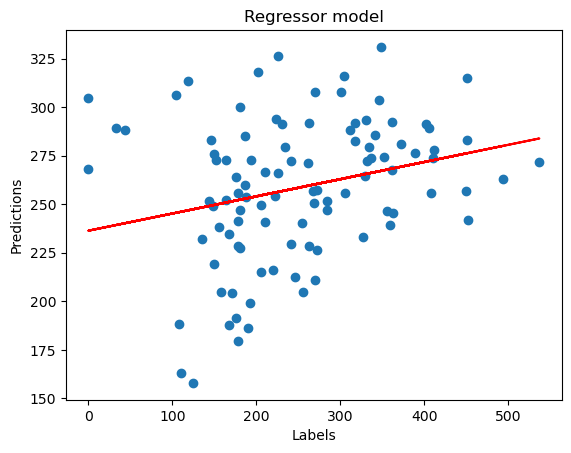

GradientBoosting model
MSE =  10223.932104622945
RMSE =  101.11346154010822
R2 =  0.16547790449406652


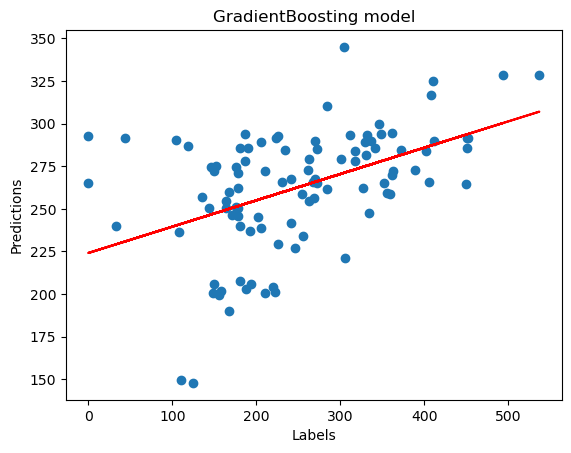

In [139]:
from sklearn.metrics import mean_squared_error, r2_score

def test_model(model, x_test, y_test, type = 'str'):
    predictions = model.predict(x_test)
    # computing the mean squared error
    mse = mean_squared_error(y_test, predictions)
    print(type)
    print("MSE = ",mse)
    # computing the root mean squared error
    rmse = np.sqrt(mse)
    print("RMSE = ",rmse)
    # computing the root mean squared error
    r2 = r2_score(y_test, predictions)
    print("R2 = ",r2)

    #do a scatterplot of the predictions vs the test set
    plt.scatter(y_test[:100], predictions[:100])
    plt.xlabel("Labels")
    plt.ylabel("Predictions")
    plt.title(type)
    z = np.polyfit(y_test[:100], predictions[:100], 1)
    p = np.poly1d(z)
    plt.plot(y_test[:100],p(y_test[:100]), color='red')
    plt.show()
    return None

test_model(model_reg , x_test, y_test, 'Regressor model')
test_model(model_boost , x_test, y_test, 'GradientBoosting model')

Although the Gradientboostingmethod performs better than the LinearRegressor, neither model is a good fit for the data, and that can be checked with an autocorrelation of the variables.

In [140]:
for column in categorical_features:
    df_firecalls[column]=df_firecalls[column].astype('category').cat.codes
df_firecalls.corr()

,City,ZIP Code,Battalion,Station Area,Suppression Units,Suppression Personnel,Response Time,FireEx Time
City,1.000000,-0.013861,-0.113303,-0.011077,-0.020283,-0.015560,-0.027193,-0.001836
ZIP Code,-0.013861,1.000000,0.508560,0.156460,-0.080522,-0.125378,0.089614,0.085776
Battalion,-0.113303,0.508560,1.000000,0.230318,-0.140284,-0.196736,0.119219,0.080461
Station Area,-0.011077,0.156460,0.230318,1.000000,-0.038586,-0.075737,0.042395,0.051381
Suppression Units,-0.020283,-0.080522,-0.140284,-0.038586,1.000000,0.946652,-0.113772,0.071206
Suppression Personnel,-0.015560,-0.125378,-0.196736,-0.075737,0.946652,1.000000,-0.153253,-0.006320
Response Time,-0.027193,0.089614,0.119219,0.042395,-0.113772,-0.153253,1.000000,0.120420
FireEx Time,-0.001836,0.085776,0.080461,0.051381,0.071206,-0.006320,0.120420,1.000000


Where none of the features has a significant correlation value towards our target variable.